# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)



In [29]:
num_test = len(newsgroups_test.target)
test_cut = int(num_test/2)
test_data, test_labels = newsgroups_test.data[test_cut:], newsgroups_test.target[test_cut:]
dev_data, dev_labels = newsgroups_test.data[:num_test-test_cut], newsgroups_test.target[:num_test-test_cut]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)


training label shape: (2034,)
test label shape: (677,)
dev label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [4]:
def P1(num_examples=5):
### STUDENT START ###
    #this function prints the label category in bold, red and its corresponding content in black below it
    for i in range(num_examples):
        print(u"\u001b[31m"+ "\033[1m"+newsgroups_train.target_names[train_labels[i]]+"\033[0m",
              "\n",
              u"\u001b[30m"+train_data[i],
              "\n")
### STUDENT END ###
P1(5)

comp.graphics 
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

talk.religion.misc 
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries. 

sci.space 
 
 >In ar

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:
[6 pts]


a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.


In [5]:
#initialize instance of class CountVectorizer 
vectorizer = CountVectorizer()
#convert a collection of text documents to a matrix of token counts and return
# a Document-term matrix [n_samples, n_features]
x = vectorizer.fit_transform(train_data)
# Note to self: most feature/token (columnwise) entries for each text document will be zero since each vector (text document row) 
# is as long as the total number of tokens in the training set and the dimension (r,c) corresponds to the number of times a token is found 
# in the corresponding document/string. As a result, its more efficient to produce a sparse matrix object
vocab_size = x.shape[1]
mean_nnz = round(x.nnz/x.shape[0],2)
proportion_nnz = round(x.nnz/(x.shape[0]*x.shape[1]),4)

print("The size of the vocabulary is",vocab_size)
print("The average number of non-zero features per example is",mean_nnz)
print("The fraction of the entries in the matrix that are non-zero are",proportion_nnz)


The size of the vocabulary is 26879
The average number of non-zero features per example is 96.71
The fraction of the entries in the matrix that are non-zero are 0.0036


b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.


In [6]:
#vectorizer.get_feature_names()
print(vectorizer.get_feature_names()[0])
print(vectorizer.get_feature_names()[-1])

00
zyxel



c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

In [7]:
# note to self: the .vocabulary_ attribute and get_feature_names method can be called from the instance of your
# CountVectorizer class only after its fitted with text documents via the fit_transform method

my_vocab = ["atheism", "graphics", "space", "religion"]
new_vectorizer = CountVectorizer(vocabulary = my_vocab)
x_1 = new_vectorizer.fit_transform(train_data)


print('The training vectors have',x_1.shape[0],'rows and',x_1.shape[1],'columns as expected.')
print("")
print('The average number of non-zero features per example is',round(x_1.nnz/x_1.shape[0],2))



The training vectors have 2034 rows and 4 columns as expected.

The average number of non-zero features per example is 0.27


d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

In [8]:
BiTriGram_vect = CountVectorizer(analyzer = "char",ngram_range=(2, 3))
bt = BiTriGram_vect.fit_transform(train_data)
print("The size of the vocabulary using bigram and trigram character features is",bt.shape[1])

The size of the vocabulary using bigram and trigram character features is 35478


e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

In [28]:
prune_vect = CountVectorizer(min_df = 10)
prune_vect_ft = prune_vect.fit_transform(train_data)
print("The size of the vocabulary after pruning words that occur in fewer than 10 documents is:",
     prune_vect_ft.shape[1])

The size of the vocabulary after pruning words that occur in fewer than 10 documents is: 3064


f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [61]:
train_CV = CountVectorizer()
dev_CV = CountVectorizer()
train_CV_ft = train_CV.fit_transform(train_data)
dev_CV_ft = dev_CV.fit_transform(dev_data)
vocab_sizeTrain = train_CV_ft.shape[1]
vocab_sizeDev = dev_CV_ft.shape[1]

print(round((vocab_sizeTrain - vocab_sizeDev)/vocab_sizeTrain,3),
      "of the words in the dev data are missing from the vocabulary in train data")


0.395 of the words in the dev data are missing from the vocabulary in train data


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:


In [7]:
def P3(train_features,dev_features,train_labels,dev_labels):
### STUDENT START ###

    #------------fit k nearest neighbors classifier, report f1 score and find the optimal value for k-----------#
  
    kn = KNeighborsClassifier()
    kn.fit(train_features,train_labels)
    kn_pred_vals = kn.predict(dev_features)

    kn_f1 = round(metrics.f1_score(dev_labels, kn_pred_vals, average='weighted'),2)

    #create a dict of n_neighbors key with list of k values to pass into param_grid argument of GridSearch
    k_vals = {'n_neighbors': [i+1 for i in np.arange(10)]}
    #pass in the K value sequence to grid search
    grd_search_knn = GridSearchCV(estimator = kn, param_grid=k_vals)
    #fit using train data
    grd_search_knn.fit(train_features, train_labels)
    
    #-----------fit a Multinomial Naive Bayes model, report f1 score and find the optimal value for alpha-------#
    
    mnb = MultinomialNB()
    mnb.fit(train_features, train_labels)
    mnb_pred_val = mnb.predict(dev_features)
    mnb_f1 = round(metrics.f1_score(dev_labels, mnb_pred_val, average='weighted'),2)
    
    #create a dict of alpha key with list of alpha float values to pass into param_grid argument of GridSearch
    alphas = {'alpha': np.linspace(0.0, 1.0, num=20)}
    #pass in the alpha value sequence to grid search
    grd_search_mnb = GridSearchCV(estimator= mnb, param_grid=alphas)
    #fit using train data
    grd_search_mnb.fit(train_features, train_labels)

     #--fit a logistic regression model, report f1 score and find the optimal value for regularization strength C--#
    
    lr = LogisticRegression()
    lr.fit(train_features, train_labels)
    lr_pred_val = lr.predict(dev_features)
    lr_f1 = round(metrics.f1_score(dev_labels, lr_pred_val, average='weighted'),2)
    
    #create a dict of key C with list of c values to pass into param_grid argument of GridSearch
    c_val = {'C':np.linspace(0.1, 2.0, num=10)}
    #pass in the alpha value sequence to grid search
    grd_search_lr = GridSearchCV(estimator = lr, param_grid=c_val)
    #fit using train data
    grd_search_lr.fit(train_features, train_labels)
    
    
    print("The f1 score for the k neighbors classifier is:"+ str(kn_f1) + 
          " and the optimal value for k is: " + str(grd_search_knn.best_estimator_.n_neighbors))
    print("")
    print("The f1 score for the multinomial naive bayes classifier is:"+ str(mnb_f1) + 
          " and the optimal value for alpha is: " + str(round(grd_search_mnb.best_estimator_.alpha,2)))
    print("")
    print("The f1 score for the logistic regression classifier is:"+ str(lr_f1) +
          " and the optimal regularization strength C value: " + str(round(grd_search_lr.best_estimator_.C,2)))

vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(train_data)
#transform dev data using the same normalizing parameters that were fitted to the train data
dev_features = vectorizer.transform(dev_data)

### STUDENT END ###

P3(train_features,dev_features,train_labels,dev_labels)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


The f1 score for the k neighbors classifier is:0.43 and the optimal value for k is: 10

The f1 score for the multinomial naive bayes classifier is:0.78 and the optimal value for alpha is: 0.05

The f1 score for the logistic regression classifier is:0.69 and the optimal regularization strength C value: 0.52


a. Why doesn't nearest neighbors work well for this problem?

This is a very high dimensional data set (relative to obsersvations) we're trying to model against. Nearest neighbors is trying to find the shortest token-frequency distances between the train and test data to predict the document's topic. There are high frequencies of tokens (words) shared across all topics which are not as informative and may be modeled better with larger k values. But there are also many low-frequency words unique to each topic that are very informative and better modeled with lower k values. The knn model needs to learn which features are more important than others. But distance isn't an ideal metric for doing so given the two contrasting behaviors mentioned above.

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

Logistic regression is a discriminative model, meaning it learns the conditional probability distribution of the topic given the feature. Naive Bayes is a generative model, meaning it learns the joint probability distribution of the topic and a feature. Because of the relatively narrow sample size of each feature, the discriminative model won't generalize as well as the generative model. Although the logistic regression model will have lower bias, it has a higher variance than the naive bayes model in this case and so it doesn't generalize as well.


c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.



In [28]:
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(train_data)
dev_features = vectorizer.transform(dev_data)
c_vals = np.linspace(.01, 5, num=10)
for c in c_vals:
    lr = LogisticRegression(C=c)
    lr.fit(train_features, train_labels)
    d = {}
    coef_len = len(lr.coef_)
    for l in np.arange(coef_len):
        d[l] = (sum(lr.coef_[l]**2))
    
    print("For C Value: ", str(c))
    print(d)


For C Value:  0.01
{0: 2.5414876825471953, 1: 2.9397093683556812, 2: 2.8624691016880601, 3: 2.2500291895155713}
For C Value:  0.564444444444
{0: 112.16515319638657, 1: 90.269631484832516, 2: 107.83947269944808, 3: 97.380835945465364}
For C Value:  1.11888888889
{0: 179.87103196969659, 1: 140.33911874436376, 2: 169.59641963331831, 3: 157.02180019126706}
For C Value:  1.67333333333
{0: 231.60778731124751, 1: 178.60407524338748, 2: 216.5029667336247, 3: 203.27460486756354}
For C Value:  2.22777777778
{0: 274.2936191911391, 1: 210.34549183290713, 2: 254.97548404916529, 3: 241.62726240141768}
For C Value:  2.78222222222
{0: 310.80075998629957, 1: 237.9763947240875, 2: 288.14226820668682, 3: 275.04662314969426}
For C Value:  3.33666666667
{0: 343.24384236160046, 1: 262.24050654473513, 2: 317.36606161136632, 3: 304.46485581167514}
For C Value:  3.89111111111
{0: 372.14777612618866, 1: 284.08257074640431, 2: 343.53519126551959, 3: 331.05175532099912}
For C Value:  4.44555555556
{0: 399.2245169

With increasing values of C, we see increasing sums of squared coef weights that demonstrate dimininshing marginal values. We know that lower values of C place greater regularization on the data and so the weight values will be lower (in either direction +/-) compared to higher higher values of C. However, at some point there is diminishing value that C provides in weighting the coefficients.


[4 pts]

ANSWER:

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [62]:
#def P4():
### STUDENT START ###
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(train_data)
#transform dev data using the same normalizing parameters that were fitted to the train data
dev_features = vectorizer.transform(dev_data)

lr = LogisticRegression()
lr.fit(train_features, train_labels)
lr_pred_val = lr.predict(dev_features)

#note: will probably want to set the C param to what i found above and then remodel

d = {}
for i in np.arange(4):
    #return top 5 weighted indices from the logistic regression model; 
        #note that argsort() sorts in ascending order so we have to reverse the order
    indx = lr.coef_[i].argsort()[::-1][0:5]
    #map top weighted indices to features
    top5_names = list(np.array(vectorizer.get_feature_names())[indx])
    #add label name and its corresponding top 5 weighted features to the empty dictionary
    d[newsgroups_train.target_names[i]] = top5_names



### STUDENT END ###
#P4()

In [54]:
# Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels.

from astropy.table import Table, Column

feature_names = [k for i,j in d.items() for k in j ]

wght_indx = [vectorizer.get_feature_names().index(f) for f in feature_names]

dd = {newsgroups_train.target_names[i]:list(lr.coef_[i][wght_indx]) for i in np.arange(4)}
dd['feature'] = feature_names
Table(dd)




alt.atheism,comp.graphics,sci.space,talk.religion.misc,feature
float64,float64,float64,float64,str10
1.12492289358,-0.398296674948,-0.420381461148,-0.395960167824,deletion
1.02802893493,-0.0967463745044,-0.320550718097,-0.834956004091,atheists
0.990357442893,-0.220786091996,-0.340716423201,-0.463313094474,bobby
0.954137229087,-0.616985280224,-0.792408212879,-0.0643588630597,religion
0.93868381419,-0.4088810967,-0.449328593138,-0.43463725664,atheism
-0.758842244046,1.93686185452,-1.33597467456,-0.762515680099,graphics
-0.581838287489,1.3455954472,-0.825897082789,-0.469693526311,image
-0.334750853678,1.2659889556,-0.806438865997,-0.626378979672,file
-0.359269578304,1.12502312485,-0.702097167267,-0.378589831125,3d


In [56]:
# Create the table again with bigram features. Any surprising features in this table?

#establish bigram features from the corpus
bigram_vect = CountVectorizer(ngram_range=(2, 2))
bigram_train_features = bigram_vect.fit_transform(train_data)
bigram_dev_features = bigram_vect.transform(dev_data)

lr = LogisticRegression()
lr.fit(bigram_train_features, train_labels)
lr_pred_val = lr.predict(bigram_dev_features)

d = {}
for i in np.arange(4):
    #return top 5 weighted indices from the logistic regression model; 
        #note that argsort() sorts in ascending order so we have to reverse the order
    indx = lr.coef_[i].argsort()[::-1][0:5]
    #map top weighted indices to features
    top5_names = list(np.array(bigram_vect.get_feature_names())[indx])
    #add label name and its corresponding top 5 weighted features to the empty dictionary
    d[newsgroups_train.target_names[i]] = top5_names


feature_names = [k for i,j in d.items() for k in j ]

wght_indx = [bigram_vect.get_feature_names().index(f) for f in feature_names]

dd = {newsgroups_train.target_names[i]:list(lr.coef_[i][wght_indx]) for i in np.arange(4)}
dd['feature'] = feature_names
Table(dd)

alt.atheism,comp.graphics,sci.space,talk.religion.misc,feature
float64,float64,float64,float64,str19
0.771668663252,-0.257725613404,-0.352085852293,-0.200642148681,claim that
0.677629111098,-0.192939095652,-0.197960655524,-0.302005088608,was just
0.649140917818,-0.882369040878,-0.821927306848,0.601474396617,cheers kent
0.633800266351,-0.238288678241,-0.195135452436,-0.170545310431,look up
0.569415623156,-0.318518057541,-0.577068258934,0.000734170898072,you are
-0.755597451304,1.31961207634,-0.613633517463,-0.699886403154,looking for
-0.379821509928,1.03721964567,-0.470812728111,-0.396644615207,comp graphics
-0.544993631572,0.972280892905,-0.531005728829,-0.507318638494,in advance
-0.428484388079,0.912644968218,-0.568742530584,-0.341453426507,is there


ANSWER:

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [71]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    # remove digits,special characters and punctuation. Then convert to lower case
    s_adj = re.sub('[^a-z]+', ' ', s.lower())
    # remove words likely to be present participles, adverbs and past tense
    return re.sub(r'\w+ing|ly|ed?','',s_adj)

### STUDENT END ###

#def P5():
### STUDENT START ###

process_vect = CountVectorizer(preprocessor=better_preprocessor)
process_train_features = process_vect.fit_transform(train_data)
process_dev_features = process_vect.transform(dev_data)

process_lr = LogisticRegression()
process_lr.fit(process_train_features, train_labels)
process_lr_pred_val = process_lr.predict(process_dev_features)

vocab_diff = train_features.shape[1] - process_train_features.shape[1]

process_lr_f1 = round(metrics.f1_score(dev_labels, process_lr_pred_val, average='weighted'),2)

print("The size of the dictionary is " + 
      str(process_train_features.shape[1]) + " which is " + 
           str(vocab_diff) + " fewer features than the unprocessed vocabulary")
print("")

print("The f1 score using a preporocessor is " + str(process_lr_f1) +
      ' which is 1 point higher than the original')

### STUDENT END ###
#P5()

The size of the dictionary is 19921 which is 6958 fewer features than the unprocessed vocabulary

The f1 score using a preporocessor is 0.71 which is 1 point higher than the original


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"?


In [8]:
#def P6():
    # Keep this random seed here to make comparison easier.
np.random.seed(0)

### STUDENT START ###
lr_l1 = LogisticRegression(penalty= 'l1', tol=.01)
lr_l1.fit(process_train_features, train_labels)
lr_l1_pred_val = lr_l1.predict(process_dev_features)

lr_l2 = LogisticRegression(tol=.01)
lr_l2.fit(process_train_features, train_labels)
lr_l2_pred_val = lr_l1.predict(process_dev_features)

nz_diff = np.count_nonzero(lr_l2.coef_) - np.count_nonzero(lr_l1.coef_)
perc_nz_diff = round(-1*nz_diff/np.count_nonzero(lr_l2.coef_),2)


print("There are " + str(nz_diff) + 
      " fewer non-zero weights using Lasso regression (l1) than Ridge regression (l2) which is a " +
     str(perc_nz_diff) + " percent difference")



There are 77816 fewer non-zero weights using Lasso regression (l1) than Ridge regression (l2) which is a -0.98 percent difference


Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).
[4 pts]

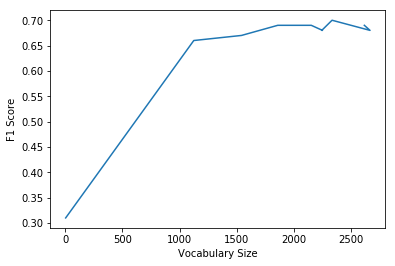

In [112]:
def P6(c_vals,train_features):
    # Keep this random seed here to make comparison easier.
    
    np.random.seed(0)
    #build c value and f1 score list
    vocab_sizes = []
    f1_scores = []
    
    for c in c_vals:

        #fit a logistic regression model per the c value
        lr = LogisticRegression(penalty= 'l1',C = c, tol=.01)
        lr.fit(train_features, train_labels)

        #extract indices of all coefficients with a non-zero weighting
        nzw_indx = np.nonzero(lr.coef_)[1]

        #iterate through the values (indices) of the vocabulary (dictionary) and pass the token 
        #with a corresponding index in the non-zero coefficient index to a list to generate the 
        #new vocabulary, then remove duplicates from the new vocabulary 
        #to pass into the CountVectorizer object

        nzw_vocab = list(set([j for j,k in vect.vocabulary_.items() if k in nzw_indx]))

        #create a new instance of CountVectorizer and pass in the non-zero-coefficient, reduced
        #vocabulary
        nzw_vect = CountVectorizer(vocabulary = nzw_vocab)
        nzw_train_features = nzw_vect.fit_transform(train_data)
        nzw_dev_features = nzw_vect.transform(dev_data)

        #retrain the non-zero-coefficient adjusted data on a new logit model with L2 regularization
        lr_retrain = LogisticRegression(C=c,tol=.01)
        lr_retrain.fit(nzw_train_features, train_labels)
        lr_retrain_pred_val = lr_retrain.predict(nzw_dev_features)

        f1 = round(metrics.f1_score(dev_labels, lr_retrain_pred_val, average='weighted'),2)
        vocab_size = len(nzw_vocab)
        vocab_sizes.append(vocab_size)
        f1_scores.append(f1)

    return vocab_sizes,f1_scores


#set train_features and c values to pass into P6 function
vect = CountVectorizer()
train_features = vect.fit_transform(train_data)     
c_vals = np.linspace(.001, 10, num=10)

x,y = P6(c_vals,train_features)

#plot the f1 scores against the vocabulary sizes
plt.plot(x, y) 
plt.ylabel('F1 Score') 
plt.xlabel('Vocabulary Size') 
plt.show()


(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

The TfidfVectorizer (term-frequency times inverse document-frequency). Tfidf scales down the weights of tokens that have high frequencies as those terms tend to be less informative. CountVectorizer doesn't do the weight adjustments on high frequency terms; instead it computes raw frequencies of occurrence of a token in a given document.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [47]:
#def P7():
    ### STUDENT START ###
    
#-----Train a logistic regression model with C=100 Using the TfidfVectorizer---------#
TD_vectorizer = TfidfVectorizer()
TD_trainFeatures = TD_vectorizer.fit_transform(train_data)
TD_devFeatures = TD_vectorizer.transform(dev_data)

TD_lr = LogisticRegression(tol=.01, C=100)
TD_lrFit = TD_lr.fit(TD_trainFeatures, train_labels)
TD_lrPredict = TD_lrFit.predict(TD_devFeatures)

TD_f1 = metrics.f1_score(dev_labels, TD_lrPredict, average='weighted')

#----------------Show the top 3 documents where the ratio R is largest-------------------------#
#----R = maximum predicted probability / predicted probability of the correct label-----------#
probs = TD_lrFit.predict_proba(TD_devFeatures)

max_probs = []
correct_label_probs = []

#iterate through each document and throw the classes' max predicted prob into a list
#simulatenously index the predicted probability of the correct label
for p in np.arange(len(probs)):
    max_probs.append(max(probs[p]))
    correct_label_probs.append(probs[p][dev_labels[p]])

R_ratios = np.array(max_probs)/np.array(correct_label_probs)
top3_Rratio = R_ratios.argsort()[::-1][0:3]
top3_Rratio

#print the documents with the top 3 R ratios
for r in top3_Rratio:
    print("True Label:", str(newsgroups_test.target_names[dev_labels[r]]),"\n")
    print("Predicted Label:", str(newsgroups_test.target_names[TD_lrPredict[r]]),"\n")
    print(dev_data[r],"\n")
    ### STUDENT END ###
#P7()

True Label: talk.religion.misc 

Predicted Label: comp.graphics 

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the perm

ANSWER:

The mistake the model is making is it tends to classify religious topics that are categorized as computer graphics. We see that the religous topics in these cases all contain ftp, email or online which is likely weighted heavier for computer graphics topics. To overcome this we could rule out features that have both high accuracy and high false positives from the training set.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance